In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import datetime
import gc
import warnings
import time
import csv
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.ticker as mticker
import pylandau
from pylandau import langau
from importlib import reload
from scipy.optimize import curve_fit, fsolve
from scipy.integrate import quad

In [3]:
fit_data_loc = r'./data/fit_data_full.csv'
fitdata = pd.read_csv(fit_data_loc)
display(fitdata)

,mpv,eta,sigma,A,e_min,e_max
0,1.727927,0.120967,0.038455,3.284104,0.100000,0.141254
1,1.857183,0.109516,0.121318,73.049835,0.141254,0.199526
2,1.823840,0.112641,0.108565,830.585409,0.199526,0.281838
3,1.797432,0.093731,0.115615,3308.998210,0.281838,0.398107
4,1.799635,0.094242,0.118135,12324.856562,0.398107,0.562341
5,1.803524,0.092866,0.119586,32245.803381,0.562341,0.794328
6,1.798343,0.089099,0.118795,58275.495991,0.794328,1.122018
7,1.810452,0.089481,0.119375,77364.559261,1.122018,1.584893
8,1.832099,0.089334,0.120932,96775.731705,1.584893,2.238721
9,1.853082,0.090370,0.122569,107589.581271,2.238721,3.162278


This fixes an issue with the <code>pylandau.langau_pdf</code> function normalization. I redefine my own langau.

In [4]:
def langau_pdf(dedx, mpv, eta, sig):
    return eta * pylandau.get_langau_pdf(dedx, mpv, eta, sig)

First we need a muon track to analyze. For now, I will read this in from the smaller dataset, make sure it satisfies the requirements of a non-stopping muon within the pitch requirements, and compute the dedx curve.

In [59]:
import uproot

test = ['trk_sce_start_x','trk_sce_start_y','trk_sce_start_z', 
        'trk_sce_end_x','trk_sce_end_y','trk_sce_end_z',
        'backtracked_e', 'backtracked_pdg']
anal = ['dedx_y', 'rr_y', 'pitch_y']
dedx_cutoff = 100
pitch_high_cutoff = 0.3 / np.cos(70*np.pi/180)     # Multiplied by 3mm for wire spacing
# pitch of greater than 70 degrees wrt collection plane is ignored

In [65]:
def load_muons(rootfile, caindex):
    muons = []
    with uproot.open(rootfile) as file:
        tree = file.values()[caindex]
        test_muons = tree.arrays(test, library='pd')
        anal_muons = tree.arrays(anal, library='pd')
        
        for i in test_muons.index:
            muon = test_muons.iloc[i].squeeze()
            muons.append(muon)

        pidx = anal_muons.index.get_level_values(0).unique()

        for p in pidx:
            anal_muon = anal_muons.loc[p,:]
            for name in anal:
                muons[p][name] = anal_muon[name].squeeze()
    
    return np.array(muons)[pidx]

I will check that the muon selected is a stopping muon by checking if *any* of the track start or end variables are within. I may want to make this identical to the previous cut used in Analyze.ipynb by putting it in theory.py. 
- This function is written pretty well, consider porting it over to the analysis. I think it is faster too.

In [8]:
def is_non_stopping_muon(ri, rf):
    dimensions = [0, 0, -116, 256, 116, 1036]
    checki = np.zeros(len(dimensions)//2)
    checkf = np.zeros(len(dimensions)//2)
    
    for i in range(len(dimensions)//2):
        start = dimensions[i]
        end = dimensions[i+3]
        thresh = (end - start)/100
        checki[i] += start+thresh
        checkf[i] += end-thresh

    enters = not ((checki < ri).all() and (checkf > ri).all())
    exits = not ((checki < rf).all() and (checkf > rf).all())
    return enters and exits

Performs all the necessary checks on the particle track data to ensure it is a particle we are capable of producing a likelihood for

In [18]:
def good_muon(muon):
    if not is_non_stopping_muon(muon.iloc[:3], muon.iloc[3:6]):
        print('Muon stops in detector, aborting analysis...')
        return False
    if muon['backtracked_e'] < 0 or muon['backtracked_e'] > 100:
        print('Muon is not in the Bethe regime')
        return False
    if np.abs(int(muon['backtracked_pdg'])) != 13:
        print("Particle is not a muon")
        return False
    if muon['pitch_y'][0] > pitch_high_cutoff:
        return False
    return True

In [10]:
def datapoint_is_invalid(de, dedx, lovercostheta, e, dedx_cutoff, pitch_high_cutoff):
    skip_rest = False
    
    if de > e:
        skip_rest = True
    if dedx > dedx_cutoff:
        skip_rest = True
    if lovercostheta > pitch_high_cutoff:
        skip_rest = True
        
    return skip_rest

In [17]:
def generate_eloss(muon):
    es = []
    dedxs = []
    
    e_losses = muon['dedx_y']
    pitch = muon['pitch_y']
    rr = muon['rr_y']
    e = muon['backtracked_e']
    
    prev_range = 0
    
    data_points = rr.index
    for d in data_points:
        x = rr[d]                                    # Particle current x
        dedx = e_losses[d]                           # Particle recent energy loss (MeV/cm)
        lovercostheta = pitch[d]                     # Pitch (For collection wires spaced by 3mm)
        de = (x - prev_range)*dedx/1000              # Approx energy lost since last step (GeV)

        if datapoint_is_invalid(de, dedx, lovercostheta, e, dedx_cutoff, pitch_high_cutoff):
            print(f"Track becomes invalid at data point {d}")
            break
        else:
            es.append(e)
            dedxs.append(dedx)
            e -= de                                  # Lower energy accordingly
            prev_range = x                           # Update prev_range

            
    return es, dedxs

The likelihood will only depend on the dedxs and the landau fit parameters. The true energies are calculated for reference. For a given dedx ($x_i$) the probability that it corresponds to a measurement from energy bin $j$ is given by:
$$p_j(x_i)=\frac{f_j(x_i)}{\sum_{k}f_k(x_i)}$$
where $f_j$ is the langau pdf associated with energy bin $j$ and the denominator is the sum of the langau pdfs at $x_i$ over all energy bins. **Assuming the $x_i$ are independent (which is wrong)**, the likelihood that all the data $x_i$ correspond to energy bin $j$ is:
$$\mathscr{L}_j=\prod_i\frac{f_j(x_i)}{\sum_k f_k(x_i)}$$
This uses an incorrect assumption that the $x_i$ are all independent. In principle, the $x_i$ should follow the Bethe-Bloch curve as each subsequent $x_i$ corresponds to an energy loss from a muon of slightly lower kinetic energy. Corrections for this effect will be implemented later. Then the matter of maximizing the likelihood is akin to selecting energy bin $j$ with the highest $\mathscr{L}$.

In [12]:
def like_max(dedxs):
    landau_params = np.array([ fitdata.iloc[i][:3] for i in range(fitdata.shape[0]) ])

    like = []

    for lp in landau_params:
        likej = 1
        for xi in dedxs:
            fj = langau_pdf(xi, *lp)
            norm = np.sum( langau_pdf(xi, *k) for k in landau_params )
            likej *= fj/norm

        like.append(likej)

    if np.array(like).any() == 0:
        print('warning: minimum floating point precision reached')

    jtilde = np.argmax(like)
    e_min_tilde, e_max_tilde = fitdata.iloc[jtilde,-2:]
    return e_min_tilde, e_max_tilde

We are approaching machine precision with these likelihoods. For longer tracks, these values will get smaller and smaller. We will need to figure out a way to deal with this, inevitably.

In [19]:
def CER(muon):  
    es, dedxs = generate_eloss(muon)
    e_min_tilde, e_max_tilde = like_max(dedxs)
    return e_min_tilde, e_max_tilde

In [66]:
rootfile = r"./data/simulated_cosmics.root"
caindex = 0
muons = load_muons(rootfile, caindex)

In [72]:
truth = []
reconstructed = []
num_bad_muons = 0
p_count = 0

tot_particles = len(muons)
pcnt_per_count = 100./tot_particles
count_per_pcnt = 1/pcnt_per_count
running_count_for_pcnt_increment = 0

for muon in muons:
    
    if p_count > running_count_for_pcnt_increment:
        print(f"{(running_count_for_pcnt_increment / tot_particles)*100:.0f}%   ", end = '\n', flush=True)
        running_count_for_pcnt_increment += count_per_pcnt
        
    p_count += 1
    if not good_muon(muon):
        num_bad_muons += 1
        continue
    
    e_min, e_max = CER(muon)
    
    true_e = muon['backtracked_e']
    truth.append(true_e)
    
    guess_e = 10**((np.log10(e_min) + np.log10(e_max))/2)
    reconstructed.append(guess_e)
    
print(num_bad_muons)

0%   
Muon stops in detector, aborting analysis...
Track becomes invalid at data point 333
Track becomes invalid at data point 8
Track becomes invalid at data point 81
Track becomes invalid at data point 108
Track becomes invalid at data point 507
Track becomes invalid at data point 8
Muon stops in detector, aborting analysis...
Track becomes invalid at data point 68
Track becomes invalid at data point 27
Track becomes invalid at data point 86
1%   
Muon is not in the Bethe regime
Track becomes invalid at data point 307
Track becomes invalid at data point 99
Track becomes invalid at data point 341
Track becomes invalid at data point 217
Track becomes invalid at data point 466
Track becomes invalid at data point 17
Muon stops in detector, aborting analysis...
Track becomes invalid at data point 146
Muon stops in detector, aborting analysis...
Muon is not in the Bethe regime
2%   
Track becomes invalid at data point 3
Track becomes invalid at data point 24
Track becomes invalid at data p

Text(0, 0.5, 'true energy')

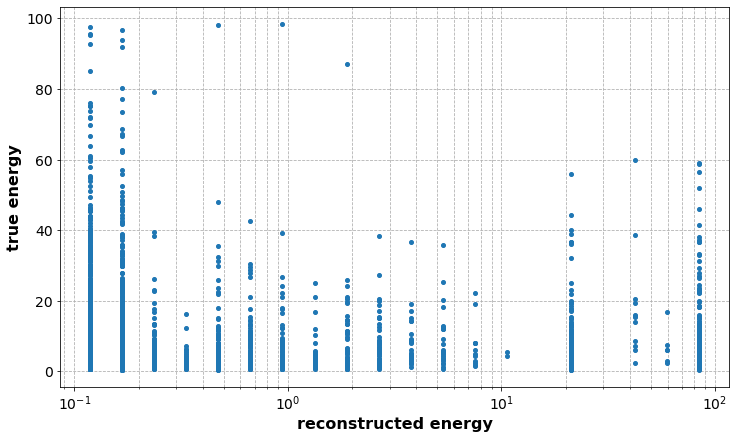

In [85]:
fig = plt.figure()
plt.style.use(r'./stylesheets/eloss.mplstyle')
plt.plot(reconstructed, truth, '.')
plt.xscale('log')
plt.xlabel('reconstructed energy')
plt.ylabel('true energy')